# Human Activity Recognition(HAR)

- Reference article: https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0
- Reference code: https://github.com/ni79ls/har-keras-coreml/blob/master/Human%20Activity%20Recognition%20with%20Keras%20and%20CoreML.ipynb
- Dataset: https://www.cis.fordham.edu/wisdm/dataset.php

---

* Convert and reformat **accelerometer data** into a **time-sliced representation**
* **Visualize** the accelerometer data
* Reshape the **multi-dimensional tabular data** so that it is accepted by Keras


## Overview

- **accelererometer data** from a smartphone
    - x, y, z axis acceleration
    - timestamp
    - person ID
- **6 acitivites**
    - Walking
    - Jogging
    - Sitting
    - Standing
    - Upstairs
    - DownStairs
- **Model**: trained to classify between each of the 6 activities.
    1. DNN
    2. 1D CNN

In [77]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings(action='ignore')

from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
# from keras.utils import np_utils

Constants
- TIME_PERIODS: the length of the time segment
- STEP_DISTANCE: the amount of overlap between two consecutive time segments

In [79]:
# set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
# print('keras version', keras.__version__)

# class labels
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

TIME_PERIODS = 80  # the number of steps within one time segment

# The steps to take from one segment to the next; if this value is equal tobTIME_PERIODS, 
# then there is no overlap between the segments
STEP_DISTANCE = 40

# Data

I used `/kaggle/input/activitydetectionimusensor/WISDM_ar_v1.1.1_raw.txt` data.
> (another dataset (later): `/kaggle/input/human-activity-recognition/time_series_data_human_activities.csv`)

In [80]:
# define some functions to read the data and show some basic info about the data

def read_data(file_path):
    column_names = ['user', 'activity', 'timestamp', 'acc_x', 'acc_y', 'acc_z']
    df = pd.read_csv(file_path, header=None, names=column_names)
    # Last column has a ";" character which must be removed
    df['acc_z'].replace(regex=True,
                         inplace=True,
                         to_replace=r';',
                         value=r'')
    # transform 'acc_z' column to float
    df['acc_z'] = df['acc_z'].apply(convert_to_float)
    
    df.dropna(axis=0, how='any', inplace=True)  # drop NaN values -> 필수!! without this, the accuracy never grow up
    
    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
    
def show_basic_dataframe_info(dataframe):
    # shape: #_rows, #_columns
    print("Number of rows in the dataframe: %i" % (dataframe.shape[0]))
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))

The original data can be downloaded from [here](https://www.cis.fordham.edu/wisdm/dataset.php).

But the original dataset file has **ParserError** in line 134634.

So, I uploaded fixed version **[here](https://www.kaggle.com/datasets/sosoyeong/wisdm-raw)**.

In [81]:
df = read_data('WISDM_ar_v1.1_raw.csv')
df = pd.read_csv('WISDM_ar_v1.1_raw.csv')

In [82]:
show_basic_dataframe_info(df)
df.head(10)

Number of rows in the dataframe: 1070172
Number of columns in the dataframe: 6


,user_id,activity,time,acc_x,acc_y,acc_z
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


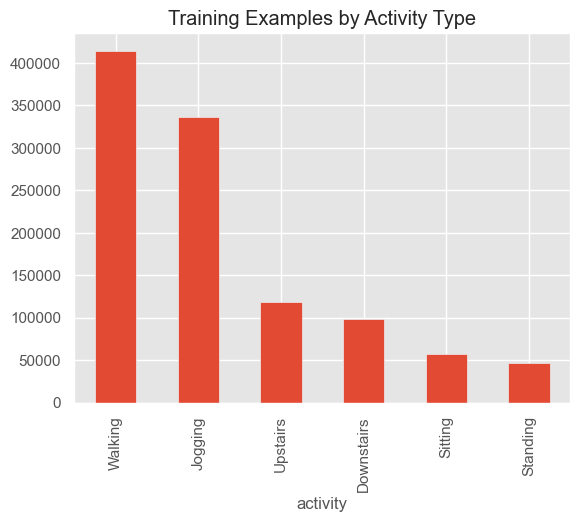

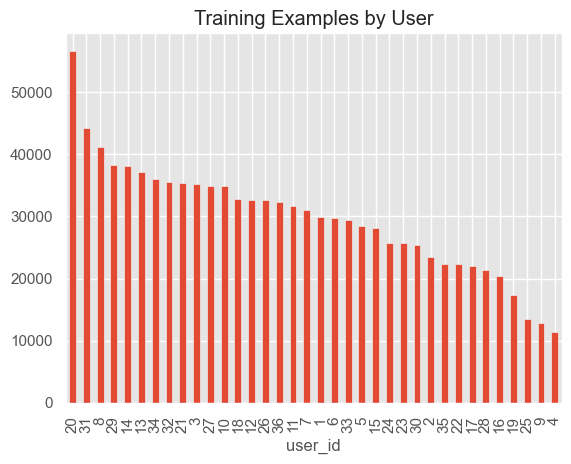

In [83]:
# by activity type
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

# by user
df['user_id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

- We have more data for walking and jogging activities more than other activities.
- 36 participants

<br>

**Accelerometer data** for six activities
- sampling rates 20Hz (20 values per second)
    - first 180 records == 9 second interval
        - 1/200 * 180 = 9 seconds

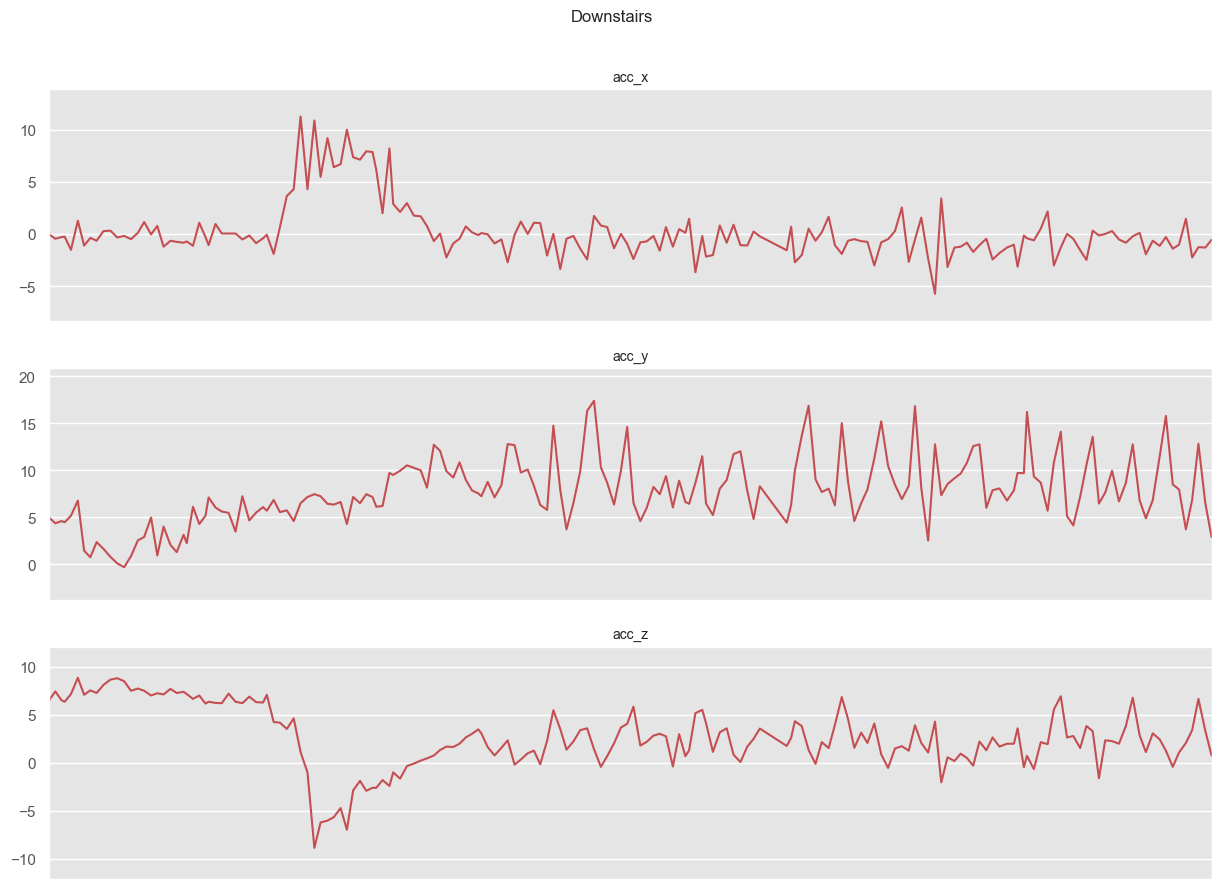

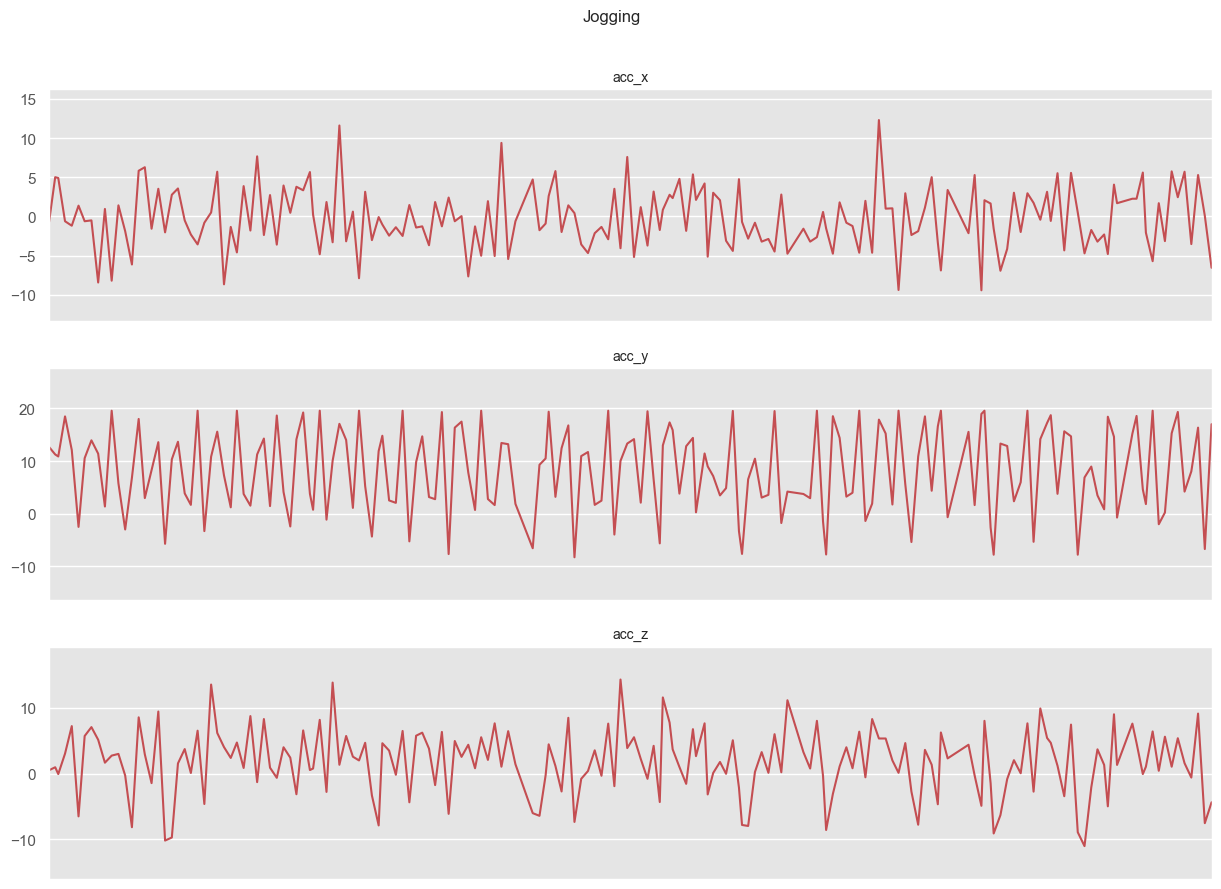

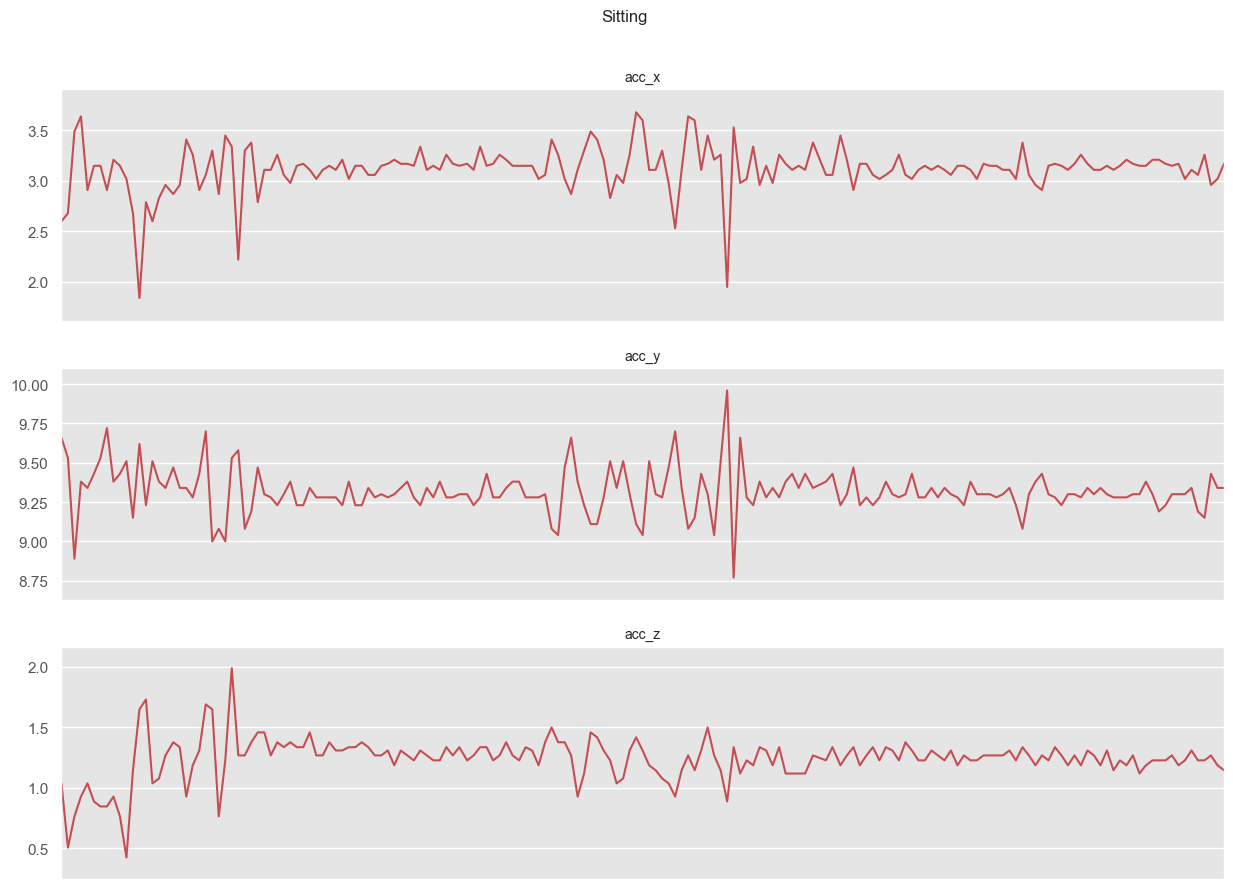

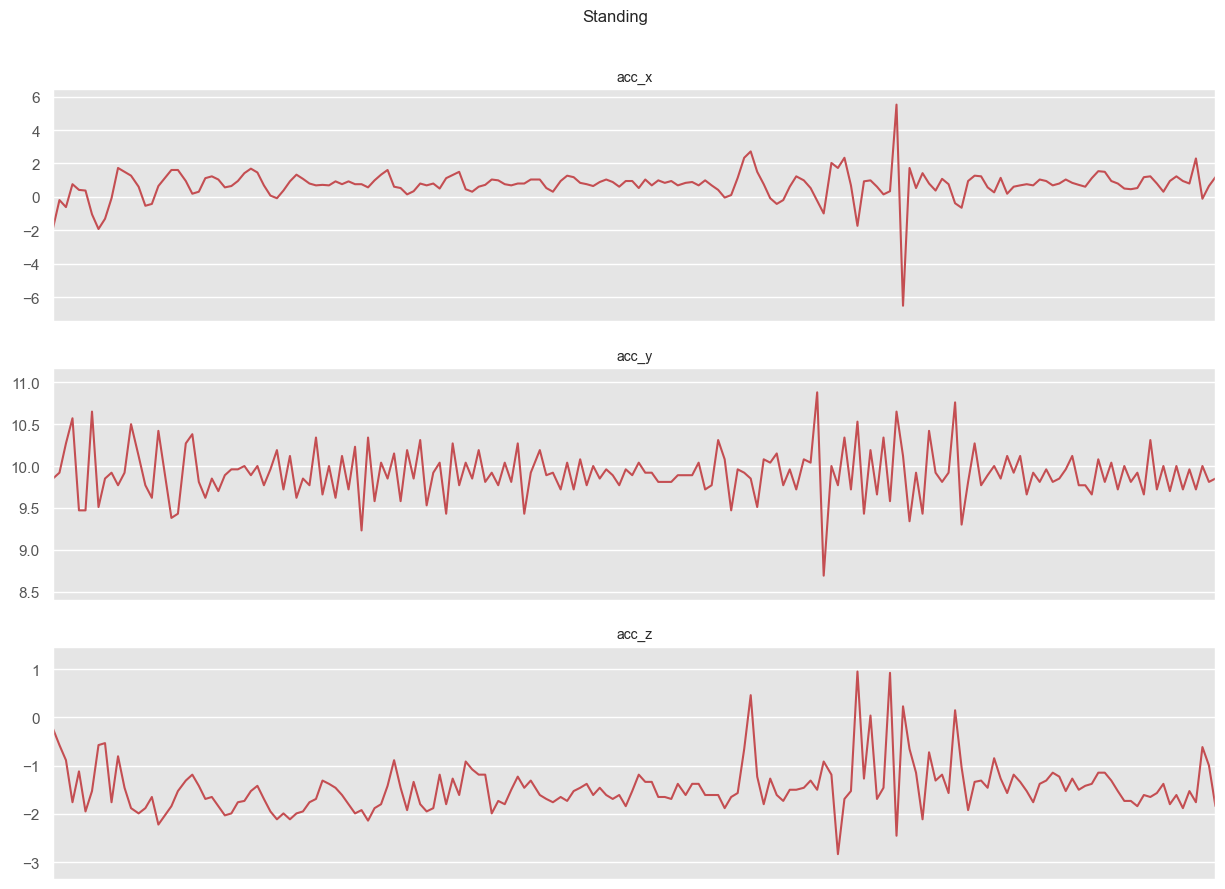

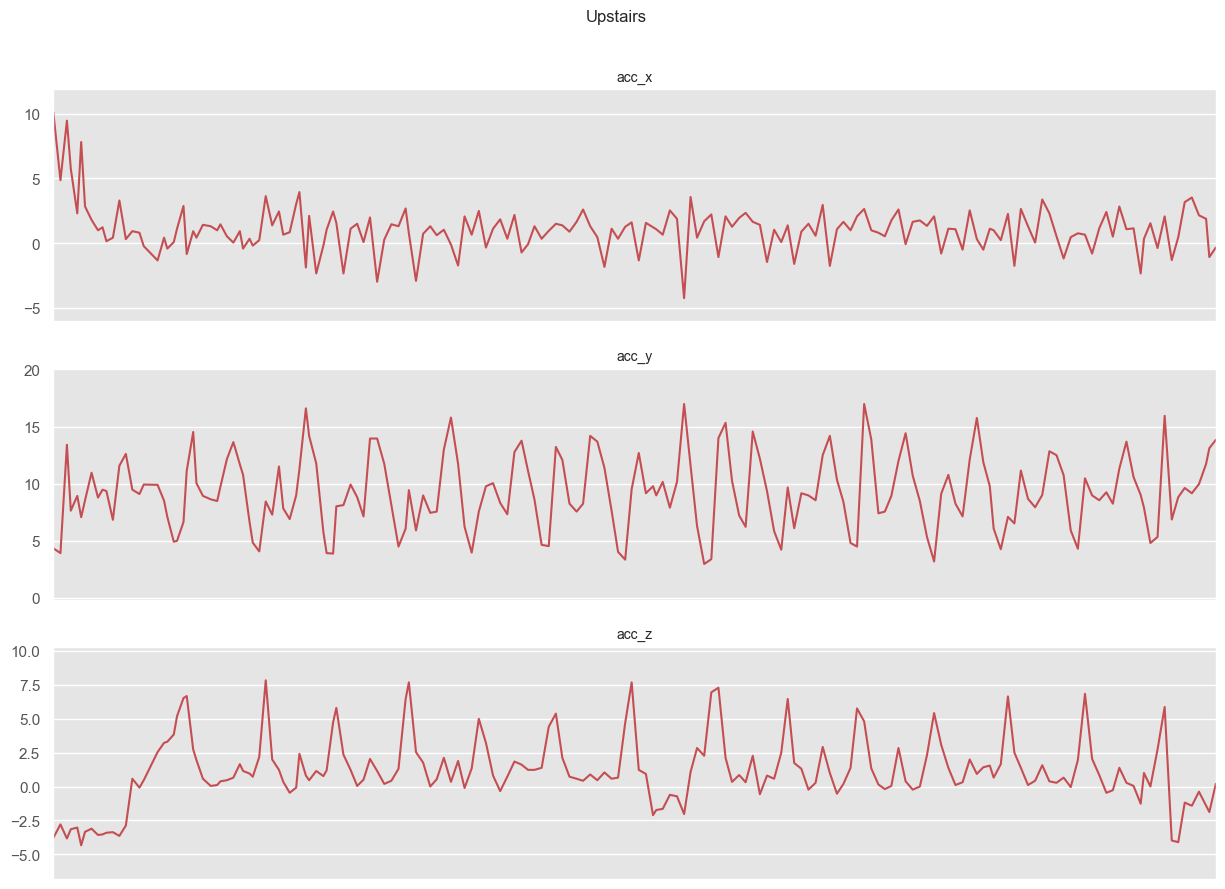

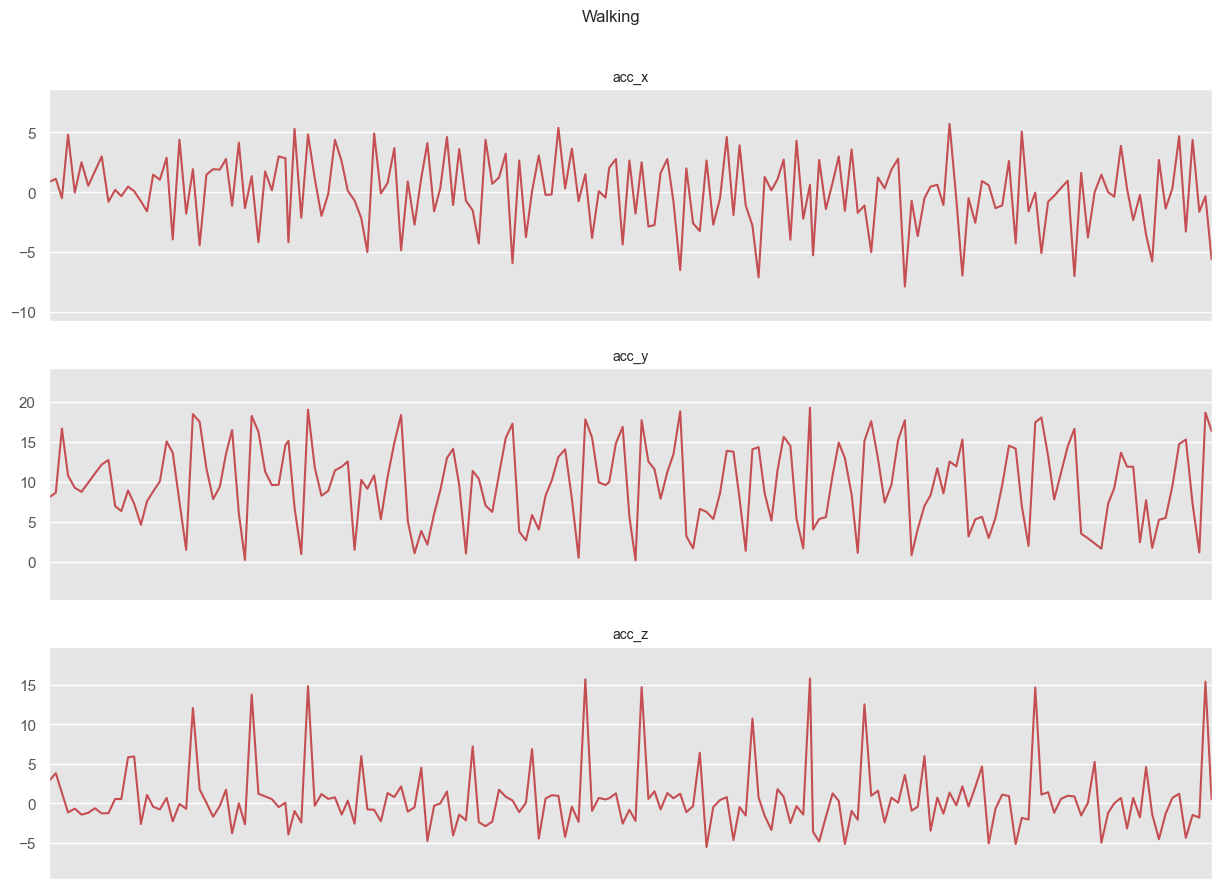

In [84]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 10), sharex=True)
    plot_axis(ax0, data['time'], data['acc_x'], 'acc_x')  # x
    plot_axis(ax1, data['time'], data['acc_y'], 'acc_y')  # y
    plot_axis(ax2, data['time'], data['acc_z'], 'acc_z')  # z
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()
    

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title, fontsize=10)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]  # check only for first 180 records (9 seconds)
    plot_activity(activity, subset)

Activies like Walking and Jogging has higher acceleration compared to Sitting.

Add **new column** called **'ActivityEncoded'** to the dataframe
- encoded value for each activity
- Why?
    - DNN only work with numerical labels
        - **need to change string label to number!**
            0. Downstairs
            1. Jogging
            2. Sitting
            3. Standing
            4. Upstairs
            5. Walking

In [85]:
df['activity'].values.ravel()

array(['Jogging', 'Jogging', 'Jogging', ..., 'Walking', 'Walking',
       'Walking'], dtype=object)

In [86]:
LABEL = 'ActivityEncoded'

le = preprocessing.LabelEncoder()  # string to Integer
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

df.head()

,user_id,activity,time,acc_x,acc_y,acc_z,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [87]:
# Split data into train and test set
# train: user 1 ~ 28
# test: user 28 ~

df_train = df[df['user_id'] <= 28]
df_test = df[df['user_id'] > 28]

In [88]:
df_train

,user_id,activity,time,acc_x,acc_y,acc_z,ActivityEncoded
8489,17,Walking,57869902574000,0.6,9.8,-0.5,5
8490,17,Walking,57870012316000,-0.0,10.2,-0.6,5
8491,17,Walking,57870122301000,-0.2,9.8,-0.7,5
8492,17,Walking,57870222246000,0.1,10.1,-0.5,5
8493,17,Walking,57870332292000,0.1,10.1,-0.6,5
...,...,...,...,...,...,...,...
1070167,19,Walking,130554011568000,0.9,14.6,1.6,5
1070168,19,Walking,130554091585000,1.3,9.1,-2.7,5
1070169,19,Walking,130554131502000,-1.9,15.6,-1.7,5
1070170,19,Walking,130554171632000,-4.5,19.7,0.2,5


In [89]:
# normalize train data (value range: 0 ~ 1)
# normalization should be applied to test data in the same way
pd.options.mode.chained_assignment = None  # defual='warm'

df_train['acc_x'] = df_train['acc_x'] / df_train['acc_x'].max()
df_train['acc_y'] = df_train['acc_y'] / df_train['acc_y'].max()
df_train['acc_z'] = df_train['acc_z'] / df_train['acc_z'].max()

# round numbers
df_train = df_train.round({'acc_x':4, 'acc_y':4, 'acc_z': 4})
df_train.head()

,user_id,activity,time,acc_x,acc_y,acc_z,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5
8492,17,Walking,57870222246000,0.0,0.5,-0.0,5
8493,17,Walking,57870332292000,0.0,0.5,-0.0,5


Still the dataframe is not ready yet to be fed into a neural network.

So, we need to reshpae it.

In [90]:
# 80 steps => 4 sec (0.05 * 80 = 4)

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3
    
    # Number of steps to advance in each iteration
    # step = time_steps # no overlap between segments
    
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['acc_x'].values[i: i + time_steps]
        ys = df['acc_y'].values[i: i + time_steps]
        zs = df['acc_z'].values[i: i + time_steps]        
        
        # find the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0]  # spicy.stats.mode: find the most, the first value
        segments.append([xs, ys, zs])
        labels.append(label)
    
    # bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    
    return reshaped_segments, labels  # x, y


x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

In [91]:
print(TIME_PERIODS, STEP_DISTANCE)

80 40


In [92]:
x_train[1]

array([[ 0.0731,  0.0771,  0.1208],
       [ 0.1898,  0.1284,  0.0771],
       [ 0.0867,  0.0423,  0.0041],
       [ 0.1038,  0.1188,  0.142 ],
       [ 0.1324,  0.1482, -0.002 ],
       [ 0.071 ,  0.1017, -0.0041],
       [ 0.0266,  0.0594,  0.1611],
       [ 0.0266,  0.0635,  0.2478],
       [ 0.3571,  0.0116,  0.0382],
       [ 0.0942,  0.0055, -0.0423],
       [ 0.142 ,  0.1789,  0.0287],
       [ 0.1017,  0.1461,  0.2806],
       [-0.071 ,  0.2035,  0.0075],
       [ 0.2403,  0.1017,  0.1208],
       [-0.0403,  0.1208,  0.2765],
       [ 0.1495,  0.0519,  0.0922],
       [ 0.0382,  0.14  ,  0.1864],
       [ 0.1386, -0.0055,  0.1092],
       [ 0.3571, -0.0444,  0.0942],
       [ 0.0963,  0.0382,  0.0348],
       [ 0.0847,  0.1557,  0.0997],
       [ 0.2724,  0.3147,  0.1188],
       [ 0.0075,  0.1693,  0.0382],
       [ 0.3646,  0.0403,  0.0498],
       [ 0.1727,  0.1789,  0.2574],
       [ 0.3229,  0.0403,  0.1577],
       [ 0.0266,  0.1673,  0.4261],
       [ 0.3935,  0.4282,  0

In [93]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20167, 80, 3)
20167 training samples
y_train shape:  (20167,)


`x_train` has 20868 records of 2D-matrix of shape 80x3.

**Dimensions we need to remeber**

- #_time periods: the number of time periods within 1 record
    - 4 second interval => 80
- #_sensors: 3 (x, y, z axis acceleration)
- #_classes: the number of the nodes for output layer -> 6

In [94]:
# input, output dimensions
n_time_periods, n_sensors = x_train.shape[1], x_train.shape[2]
n_classes = le.classes_.size
print(list(le.classes_))
print(n_time_periods, n_sensors)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
80 3


The input data is 2D (80x3).


In [95]:
input_shape = (n_time_periods * n_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input shape:', input_shape)

x_train shape: (20167, 240)
input shape: 240


In [96]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [97]:
# y_train_hot = np_utils.to_categorical(y_train, n_classes)
y_train_hot = tf.one_hot(y_train, depth=n_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20167, 6)


# Deep Neural Network

In [98]:
model_m = Sequential()

model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(n_classes, activation='softmax'))

model_m.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 80, 3)             0         
                                                                 
 dense_8 (Dense)             (None, 80, 100)           400       
                                                                 
 dense_9 (Dense)             (None, 80, 100)           10100     
                                                                 
 dense_10 (Dense)            (None, 80, 100)           10100     
                                                                 
 flatten_2 (Flatten)         (None, 8000)              0         
                                                                 
 dense_11 (Dense)            (None, 6)                 48006     
                                                                 
Total params: 68606 (267.99 KB)
Trainable params: 6860

In [99]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

In [100]:
BATCH_SIZE = 20
EPOCHS = 10

history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/10
807/807 [==============================] - 10s 11ms/step - loss: nan - accuracy: 0.1035 - val_loss: nan - val_accuracy: 0.0630
Epoch 2/10
807/807 [==============================] - 8s 9ms/step - loss: nan - accuracy: 0.0956 - val_loss: nan - val_accuracy: 0.0630


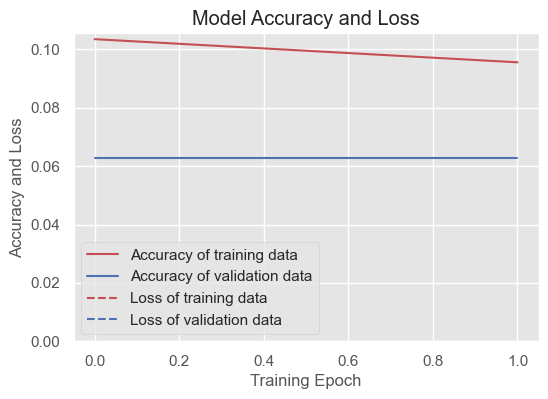

631/631 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

         0.0       0.09      1.00      0.16      1796
         1.0       0.00      0.00      0.00      6406
         2.0       0.00      0.00      0.00       988
         3.0       0.00      0.00      0.00       781
         4.0       0.00      0.00      0.00      2235
         5.0       0.00      0.00      0.00      7961

    accuracy                           0.09     20167
   macro avg       0.01      0.17      0.03     20167
weighted avg       0.01      0.09      0.01     20167


In [101]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


# Predict => confusion matrix for train data
y_pred_train = model_m.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)  # class with the highest probabilty
print(classification_report(y_train, max_y_pred_train))  # confusion matrix: classification_report from sklearn

Result from the article

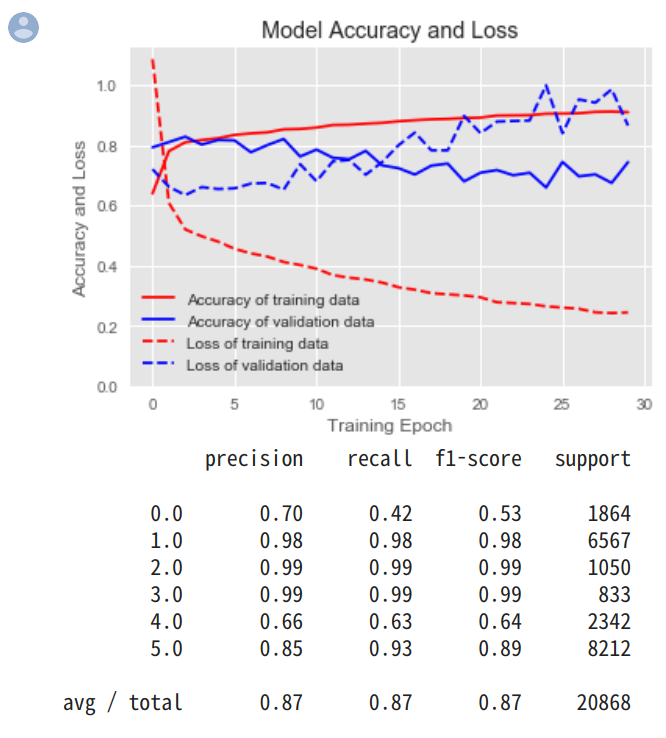

## Test

In [102]:
# normalize test data

df_test['acc_x'] = df_test['acc_x'] / df_test['acc_x'].max()
df_test['acc_y'] = df_test['acc_y'] / df_test['acc_y'].max()
df_test['acc_z'] = df_test['acc_z'] / df_test['acc_z'].max()

df_test = df_test.round({'acc_x':4, 'acc_y':4, 'acc_z': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

# y_test = np_utils.to_categorical(y_test, n_classes)
y_test = tf.one_hot(y_test, depth=n_classes)

score_dnn = model_m.evaluate(x_test, y_test, verbose=1)

print()
print('Accuracy on test data: %0.3f' % score_dnn[1])
print('Loss on test data: %0.3f' % score_dnn[0])

206/206 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.0986

Accuracy on test data: 0.099
Loss on test data: nan


The test accuray is **about 75%**.

206/206 [==============================] - 1s 5ms/step


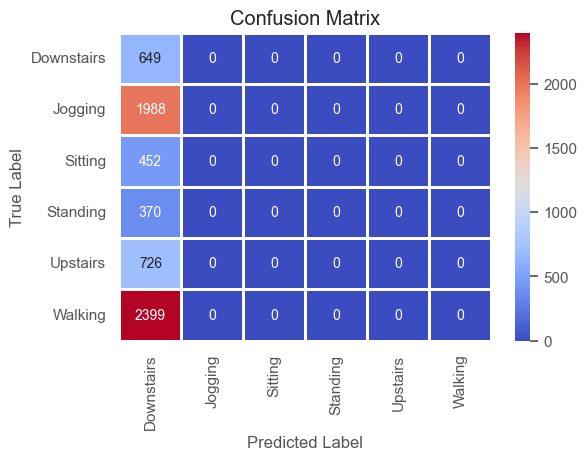

              precision    recall  f1-score   support

           0       0.10      1.00      0.18       649
           1       0.00      0.00      0.00      1988
           2       0.00      0.00      0.00       452
           3       0.00      0.00      0.00       370
           4       0.00      0.00      0.00       726
           5       0.00      0.00      0.00      2399

    accuracy                           0.10      6584
   macro avg       0.02      0.17      0.03      6584
weighted avg       0.01      0.10      0.02      6584


In [103]:
def show_confusion_matrix(validaitons, predictions, title=None):
    matrix = metrics.confusion_matrix(validaitons, predictions)
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    if title: plt.title(title) 
    else: plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

### Result

The precision is good for predicting jogging, sitting, standing, and walking (1, 2, 3, 5).
- Not good for identifying upstairs and downstairs activities (0, 6).


> By author...
>
> There is of course still great potential for improving the model, e.g. by using more advanced neural network like c**onvolutional neural networks (CNN)** or **Long Short Term Memory (LSTM)**. 

---

# 1D CNN

* Reference article: https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
* Reference code: https://github.com/ni79ls/har-keras-cnn/blob/master/20180903_Keras_HAR_WISDM_CNN_v1.0_for_medium.py

 A 1D CNN is very effective when you expect to derive interesting features from shorter (fixed-length) segments of the overall data set and where the location of the feature within the segment is not of high relevance.
 
 
This applies well to the analysis of time sequences of sensor data (such as gyroscope or accelerometer data). It also applies to the analysis of any kind of signal data over a fixed-length period (such as audio signals).

![image.png](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*aBN2Ir7y2E-t2AbekOtEIw.png)

![image.png](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*Y117iNR_CnBtBh8MWVtUDg.png)

In [104]:
model = Sequential()

model.add(Reshape((TIME_PERIODS, n_sensors), input_shape=(input_shape,)))
model.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, n_sensors)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 80, 3)             0         
                                                                 
 conv1d (Conv1D)             (None, 71, 100)           3100      
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 100)           100100    
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 100)           0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 160)           160160    
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 160)            256160    
                                                     

* Input data: The data has been preprocessed in such a way that each data record contains 80 time slices (data was recorded at 20 Hz sampling rate, therefore each time interval covers four seconds of accelerometer reading). Within each time interval, the three accelerometer values for the x axis, y axis and z axis are stored. This results in an 80 x 3 matrix. Since I typically use the neural network within iOS, the data must be passed into the neural network as a flat vector of length 240. The first layer in the network must reshape it to the original shape which was 80 x 3.
* First 1D CNN layer: The first layer defines a filter (or also called feature detector) of height 10 (also called kernel size). Only defining one filter would allow the neural network to learn one single feature in the first layer. This might not be sufficient, therefore we will define 100 filters. This allows us to train 100 different features on the first layer of the network. The output of the first neural network layer is a 71 x 100 neuron matrix. Each column of the output matrix holds the weights of one single filter. With the defined kernel size and considering the length of the input matrix, each filter will contain 71 weights.
* Second 1D CNN layer: The result from the first CNN will be fed into the second CNN layer. We will again define 100 different filters to be trained on this level. Following the same logic as the first layer, the output matrix will be of size 62 x 100.
* Max pooling layer: A pooling layer is often used after a CNN layer in order to reduce the complexity of the output and prevent overfitting of the data. In our example we chose a size of three. This means that the size of the output matrix of this layer is only a third of the input matrix.
* Third and fourth 1D CNN layer: Another sequence of 1D CNN layers follows in order to learn higher level features. The output matrix after those two layers is a 2 x 160 matrix.
* Average pooling layer: One more pooling layer to further avoid overfitting. This time not the maximum value is taken but instead the average value of two weights within the neural network. The output matrix has a size of 1 x 160 neurons. Per feature detector there is only one weight remaining in the neural network on this layer.
* Dropout layer: The dropout layer will randomly assign 0 weights to the neurons in the network. Since we chose a rate of 0.5, 50% of the neurons will receive a zero weight. With this operation, the network becomes less sensitive to react to smaller variations in the data. Therefore it should further increase our accuracy on unseen data. The output of this layer is still a 1 x 160 matrix of neurons.
* Fully connected layer with Softmax activation: The final layer will reduce the vector of height 160 to a vector of six since we have six classes that we want to predict (“Jogging”, “Sitting”, “Walking”, “Standing”, “Upstairs”, “Downstairs”). This reduction is done by another matrix multiplication. Softmax is used as the activation function. It forces all six outputs of the neural network to sum up to one. The output value will therefore represent the probability for each of the six classes.

In [105]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss',
        save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [106]:
y_train = np_utils.to_categorical(y_train, n_classes)
y_train.shape

AttributeError: module 'np_utils' has no attribute 'to_categorical'

In [ ]:
BATCH_SIZE = 400
EPOCHS = 50

history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    verbose=1)

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

The accuracy of the train data reaches over 90%.

In [ ]:
# test
# normalization of the test data is already done
score_1d = model.evaluate(x_test, y_test, verbose=1)

print()
print("Accuracy on test data: %0.3f" % score_1d[1])
print("Loss on test data: %0.3f" % score_1d[0])

In [ ]:
# confusion matrix

y_pred_test = model.predict(x_test)

max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

---

# My own trial

So far, I've used the model part code in the reference article.
But the article uses coreML, so it flattens the input data.


**I don't need to use coreML, so I'll use the non-flatten multi-dimensional data as input.**

In [ ]:
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)  # LABEL = 'ActivityEncoded'

In [ ]:
x_train.shape, y_train.shape

In [ ]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

y_train_hot = np_utils.to_categorical(y_train, n_classes)  # 그냥 integer value인 것을 one-hot encoding으로 변환
print('One-hot y_train shape: ', y_train_hot.shape)

## Model 1

In [ ]:
model_1 = Sequential()

model_1.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, n_sensors)))
model_1.add(Conv1D(100, 10, activation='relu'))
model_1.add(MaxPooling1D(3))
model_1.add(Conv1D(160, 10, activation='relu'))
model_1.add(Conv1D(160, 10, activation='relu'))
model_1.add(GlobalAveragePooling1D())
model_1.add(Dropout(0.5))
model_1.add(Dense(n_classes, activation='softmax'))

model_1.summary()

In [ ]:
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history1 = model_1.fit(x_train,
                        y_train_hot,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        validation_split=0.2,
                        verbose=1)

## Model 2

In [ ]:
model_2 = Sequential()

model_2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(TIME_PERIODS, n_sensors)))  # (80, 3)
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Flatten())
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(100, activation='relu'))
model_2.add(Dense(n_classes, activation='softmax'))

model_2.summary()

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss',
        save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

In [ ]:
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history2 = model_2.fit(x_train,
                        y_train_hot,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        validation_split=0.2,
                        verbose=1)

## Model 3

In [ ]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()

model_lstm.add(LSTM(64, input_shape=(TIME_PERIODS, n_sensors)))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(n_classes, activation='softmax'))

model_lstm.summary()

In [ ]:
model_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history3 = model_lstm.fit(x_train,
                        y_train_hot,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        validation_split=0.2,
                        verbose=1)

## Model 4

In [ ]:
model_lstm2 = Sequential()

model_lstm2.add(LSTM(64, input_shape=(TIME_PERIODS, n_sensors)))
model_lstm2.add(Dense(100, activation='relu'))
model_lstm2.add(Dense(100, activation='relu'))
model_lstm2.add(Dense(100, activation='relu'))
model_lstm2.add(Dense(n_classes, activation='softmax'))

model_lstm2.summary()

callbacks_list_2 = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss',
        save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
]

In [ ]:
model_lstm2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history4 = model_lstm2.fit(x_train,
                        y_train_hot,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks_list_2,
                        validation_split=0.2,
                        verbose=1)

In [ ]:
models = [model_1, model_2, model_lstm, model_lstm2]
histories = [history1, history2, history3, history4]

plt.figure(figsize=(18, 16))

# Plot Training Accuracy for each model
plt.subplot(2, 2, 1)
for i, history in enumerate(histories):
    plt.plot(history.history['accuracy'], label=f"Model {i+1}")

plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0, 1)
plt.legend()

# Plot Validation Accuracy for each model
plt.subplot(2, 2, 2)
for i, history in enumerate(histories):
    plt.plot(history.history['val_accuracy'], label=f"Model {i+1}")

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0, 1)
plt.legend()

# Plot Training Loss for each model
plt.subplot(2, 2, 3)
for i, history in enumerate(histories):
    plt.plot(history.history['loss'], label=f"Model {i+1}")

plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()

# Plot Validation Loss for each model
plt.subplot(2, 2, 4)
for i, history in enumerate(histories):
    plt.plot(history.history['val_loss'], label=f"Model {i+1}")

plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, n_classes)

y_test.shape

In [ ]:
res = []

# Evaluate on test data!
for i, model in enumerate(models):    
    # Evaluate the model on test data
    score = model.evaluate(x_test, y_test, verbose=1)
    res.append(score)

    # Confusion matrix
    y_pred_test = model.predict(x_test)
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(y_test, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test, f"Model {i+1}")

    # Classification report
    print(classification_report(max_y_test, max_y_pred_test))
    print()

In [ ]:
print("[Model DNN] Loss: {:.3f}, Acc: {:.3f}".format(score_dnn[0], score_dnn[1]))
print("[Model 1D Conv] Loss: {:.3f}, Acc: {:.3f}".format(score_1d[0], score_1d[1]))      
print("-------------------------------------------")

for i, result in enumerate(res):
    print('[Model {}] Loss: {:.3f}, Acc: {:.3f}'.format(i, result[0], result[1]))

## Final Result

- Model 0: 1D CNN (exactly the same architecture with the Model 1D Conv)
- Model 1: My 1D CNN (just for practice, try little bit different arch)
- Model 2: LSTM (early stopping)
- Model 3: LSTM

<br>

#### **Model 0** has the best accuracy.